In [1]:
using LinearAlgebra
using Plots
#using Flux.Data
using PyCall
@pyimport pickle
@pyimport numpy as np
using ScikitLearn
@sk_import datasets: fetch_openml

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:399
└ @ PyCall C:\Users\Sunmo Koo\.julia\packages\PyCall\zqDXB\src\PyCall.jl:399


PyObject <function fetch_openml at 0x000000005B8485E0>

 y = 0   if  w1x1 + w2x2 ≤ θ

   = 1   if  w1x1 + w2x2 > θ

θ = -b로 아래와 같이 치환 가능

 y = 0   if  b + w1x1 + w2x2 ≤ 0
 
   = 1   if  b + w1x1 + w2x2 > 0

In [2]:
function AND(x1,x2)
    x = [x1 x2]
    w = [0.5 0.5]       # w1 = w2 ≤ theta
    b = -0.6
    tmp = dot(x,w) + b
    if tmp <= 0
        return 0
    elseif tmp > 0             # 0.5를 넘으면 1, 못넘으면 0 반환
        return 1
    end
end

AND (generic function with 1 method)

In [3]:
AND(1,1)

1

In [4]:
function NAND(x1,x2)
    x = [x1 x2]
    w = [-0.5 -0.5]        # AND 게이트의 것을 부호반전 시키면 된다.
    b = 0.6
    tmp = dot(x,w) + b
    if tmp <= 0
        return 0
    elseif tmp > 0
        return 1
    end
end

NAND (generic function with 1 method)

In [5]:
NAND(0,0)

1

In [6]:
function OR(x1, x2)
    x = [x1 x2]
    w = [0.5 0.5]
    b = -0.3              # w1 = w2 > theta
    tmp = dot(w,x) + b
    if tmp <= 0
        return 0
    else
        return 1
    end
end

OR (generic function with 1 method)

In [7]:
OR(0,0)

0

In [8]:
function XOR(x1, x2)
    s1 = NAND(x1, x2)
    s2 = OR(x1, x2)
    y = AND(s1, s2)
    return y
end

XOR (generic function with 1 method)

In [9]:
XOR(1,1)

0

graph 도식에서, 노드는 x, 화살표는 w값을 가진다.

$x_k$노드에서 $w_k$가중치(화살표)로 결과값 y를 구하는 경우 : 
$a=w_1x_1+w_2x_2+b$

$b$는 편향이다. 값이 항상 1로 고정된 노드에서 출발한다고 생각해도 됨.

퍼셉트론은 이진분류를 한다 : $y=\begin{matrix}0 & if\quad a\le0\\1 & if\quad a>0\end{matrix}$

이진분류하는 퍼셉트론이 아닌 Sigmoid 등의 함수로 대체할 수 있다. 

$$y=h(a=w_1x_1+w_2x_2+b)$$
### 시그모이드 함수 :
$$h(x)=\frac{1}{1+exp(-x)}$$


In [2]:
# 계단함수 구현
function step_function(x)
    if x>0
        return 1
    else
        return 0
    end
end

# 이렇게도 가능하다.
function step_function(x)
    y = map(a -> convert(Int64,a>0), x)
    return y
end

# 시그모이드
function sigmoid(x)
    return map(a -> 1/(1+exp(-a)), x)
end

# ReLU
function relu(x)
    return map(a -> maximum([0,0.3a]), x)
end

relu (generic function with 1 method)

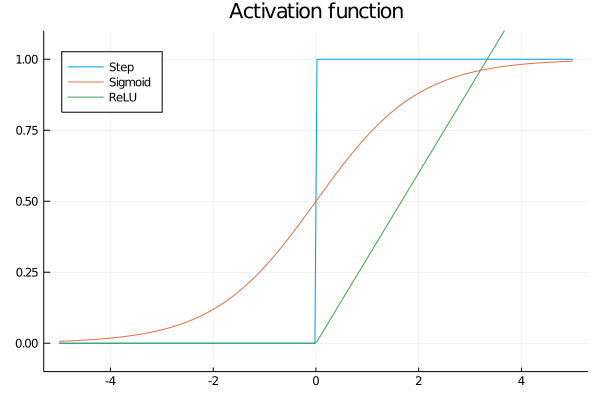

In [3]:
x=range(-5,stop=5,length=250)
ystp=step_function(x)
ysig=sigmoid(x)
yrel=relu(x)
plot(x, ystp, title="Activation function", label="Step",
    ylims=(-0.1,1.1), legend=:topleft)
plot!(x, ysig,label="Sigmoid")
plot!(x, yrel,label="ReLU")

## 신경망에서 비선형 함수만 활성화 함수로 사용하는 이유

선형 함수인 $h(x)=cx$를 활성화함수로 사용하여 3층의 신경망을 만들 경우

$$y(x)=h(h(h(x)))=c*c*c*x=ax$$

이와 같이 $a=c^3$인 $y(x)=ax$가 되므로 신경망의 층을 깊게 하는 의미가 없게 된다.


In [4]:
# 다차원 배열
B = [[1 2];[3 4];[5 6]]
print(B)
B

[1 2; 3 4; 5 6

3×2 Array{Int64,2}:
 1  2
 3  4
 5  6

]

In [5]:
A = [[1 2];[3 4]]
B = [[5 6];[7 8]]
A*B

2×2 Array{Int64,2}:
 19  22
 43  50

In [6]:
A = [[1 2];[3 4];[5 6]]
B = [7,8]    # [7 8] 이라고 하면 1×2 , [7,8] 이라고 해야 2×1
A*B

3-element Array{Int64,1}:
 23
 53
 83

In [7]:
# x₁,x₂에서 y₁,y₂,y₃로 가는 신경망
X=[1 2]      # X : 1×2 ,  W : 2×3
W=[[1 3 5];[2 4 6]]
X*W

1×3 Array{Int64,2}:
 5  11  17

##### 2개의 input, 2개의 output과 3개의 1층 은닉노드, 2개의 2층 은닉노드가 있는 경우.

입력노드 $x_i$에서 1층의 은닉노드 $a_j^{(1)}$로 향하는 가중치를 표기할 때,
$$w_{j\; i}^{(1)}$$
라고 표기한다. 하첨자에 다음층에서의 순번과 이전층에서의 순번, 윗첨자에 다음층의 층 번호를 기입한다.

1층의 첫번째 은닉노드가 가지는 값은 다음이 된다.

$$a_1^{(1)}=w_{11}^{(1)}x_1+w_{12}^{(1)}x_2+b^{(1)}$$

1층의 모든 은닉노드가 가지는 값을 행렬연산으로 나타낼 수도 있다.

$$A^{(1)}=XW^{(1)}+B^{(1)}$$

각 행렬은 다음을 뜻한다.

$$A^{(1)}=[a_1^{(1)} \: a_2^{(1)} \: a_3^{(1)}],\;
B^{(1)}=[b_1^{(1)} \: b_2^{(1)} \: b_3^{(1)}]$$

$$X^{(1)}=[x_1 \: x_2],\; 
W^{(1)}=\begin{bmatrix} w_{11}^{(1)}&w_{21}^{(1)}&w_{31}^{(1)} \\ 
w_{12}^{(1)}&w_{22}^{(1)}&w_{32}^{(1)} \end{bmatrix}$$

In [8]:
# 위의 식을 코드로 구현

X=[1.0 0.5]
W1 = [[0.1 0.3 0.5];[0.2 0.4 0.6]]
B1 = [0.1 0.2 0.3]

println(size(W1))
println(size(X))
println(size(B1))

A1 = X*W1 + B1

(2, 3)
(1, 2)
(1, 3)


1×3 Array{Float64,2}:
 0.3  0.7  1.1

활성화함수를 이용해 $Z_1 = h(A_1)$를 만들도록 한다.

In [9]:
Z1 = sigmoid(A1)

1×3 Array{Float64,2}:
 0.574443  0.668188  0.75026

In [10]:
# 입력층-1층에 이어 1층-2층 구현.
W2 = [[0.1 0.4];[0.2 0.5];[0.3 0.6]]
B2 = [0.1 0.2]

println(size(Z1))
println(size(W2))
println(size(B2))

A2 = Z1*W2 + B2
Z2 = sigmoid(A2)

(1, 3)
(3, 2)
(1, 2)


1×2 Array{Float64,2}:
 0.626249  0.771011

In [11]:
# 2층-출력층
function identity_function(x)   # 코드 구조 통일을 위해 항등함수 정의
    return x
end

W3 = [[0.1 0.3];[0.2 0.4]]
B3 = [0.1 0.2]

A3 = Z2*W3 + B3
Y = identity_function(A3)

1×2 Array{Float64,2}:
 0.316827  0.696279

In [12]:
## 3층 신경망을 함수로 구현

function init_network()     # 가중치,편향 초기값
    network = Dict()
    network["W1"]=[[0.1 0.3 0.5];[0.2 0.4 0.6]]
    network["b1"]=[0.1 0.2 0.3]
    network["W2"]=[[0.1 0.4];[0.2 0.5];[0.3 0.6]]
    network["b2"]=[0.1 0.2]
    network["W3"]=[[0.1 0.3];[0.2 0.4]]
    network["b3"]=[0.1 0.2]
    return network
end

function forward(network, x, actfunction = relu)
    W1,W2,W3 = network["W1"],network["W2"],network["W3"]
    b1,b2,b3 = network["b1"],network["b2"],network["b3"]
    
    a1 = x*W1 + b1
    z1 = actfunction(a1)
    a2 = z1*W2 + b2
    z2 = actfunction(a2)
    a3 = z2*W3 + b3
    y = identity_function(a3)
    
    return y
end


forward (generic function with 2 methods)

In [13]:
network = init_network()
x = [1.0 0.5]
y = forward(network,x,sigmoid)
print(y)

[0.3168270764110298 0.6962790898619668]

## 출력층 설계

마지막 layer의 활성화 함수에 따라 회귀 및 분류모델이 된다.

회귀모델에서는 지금까지 해온 것과 같이 $y_i=a_i$로 표현되는 항등함수를 사용하는 것이 일반적이고, 분류모델은 Softmax 함수를 사용한다.

$$y_k=\frac{exp(a_k)}{\sum_{i=1}^n exp(a_i)}$$

도식으로 표현할땐 마지막 은닉층에서 모든 화살표가 출력층으로 가게 된다. 항등함수와 달리 각 은닉노드가 모두 영향을 주기 때문.

딥러닝 분류모델에서 결과값의 대소관계는 Softmax를 거치나 안거치나 똑같기때문에, 훈련할때에는 Softmax를 사용하지만, 추론할때는 생략하고 가장 큰 값만 파악하여 출력한다.

In [14]:
function softmax(a)
    exp_a = map(i -> exp(i), a)
    sum_exp_a = sum(exp_a)
    y = exp_a / sum_exp_a
    return y
end

softmax (generic function with 1 method)

#### Softmax에서 오버플로우를 막는 방법

exponential 연산은 출력값이 매우 크게 될 수도 있으므로(예를 들어 $e^{10}=22026$, $e^{20}=485165195$) 컴퓨터의 표현 한계를 뛰어넘을 수도 있게 된다. 그러한 값들로 나눗셈을 하면 결과값도 불안정해진다.
$$  y_k=\frac{C\,exp(a_k)}{C\sum_{n=i}^n exp(a_i)} = \frac{exp(a_k+log\,C)}{\sum_{n=i}^n exp(a_i+log\,C)} 
=\frac{exp(a_k+C')}{\sum_{n=i}^n exp(a_i+C')} $$

$C'$은 아무 값이나 넣어도 성립한다. 보통 입력신호 중 최댓값을 음수로 하여 투입하는게 일반적이다.

In [15]:
# Overflow 방지처리된 Softmax 함수
function softmax(a)
    c = maximum(a)
    exp_a = map(i -> exp(i-c), a)
    sum_exp_a = sum(exp_a)
    y = exp_a / sum_exp_a
    return y
end

softmax (generic function with 1 method)

In [16]:
#X_train = Data.MNIST.images()
#y_train = Data.MNIST.labels()
#X_test = Data.MNIST.images(:test)
#y_test = Data.MNIST.labels(:test)
#print()

In [25]:
#print(size(X_train)," ",size(y_train)," ",size(X_test)," ",size(y_test))

(60000,) (60000,) (10000,) (10000,)

In [26]:
#Xtr = map(i -> reshape(i,784), X_train)
#Xte = map(i -> reshape(i,784), X_test)
#println(size(X_train[1]));print(size(Xtr[1]))

(28, 28)
(784,)

In [17]:
# PyCall 기능을 통해 파이썬용으로 만들어진 pkl파일을 가져온다.
function getpickle(filename)
    r = nothing
    @pywith pybuiltin("open")(filename,"rb") as f begin
        r = pickle.load(f)
    end
    return r
end

getpickle (generic function with 1 method)

In [18]:
mnist = fetch_openml("mnist_784", version=1)
pyX, pyy = mnist["data"]/255, mnist["target"]
pyy = np.array(pyy)
pyy = [parse(Int, x) for x in pyy]
pyX_train,pyX_test=pyX[begin:60000,:],pyX[60001:end,:]
pyy_train,pyy_test=pyy[begin:60000],pyy[60001:end]

([5, 0, 4, 1, 9, 2, 1, 3, 1, 4  …  9, 2, 9, 5, 1, 8, 3, 5, 6, 8], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [19]:
function init_network()
    network = getpickle("C:\\Users\\Sunmo Koo\\Desktop\\Data\\sample_weight.pkl")
    return network
end

function predict(network, x, actfunc = sigmoid)
    W1,W2,W3 = network["W1"],network["W2"],network["W3"]
    b1,b2,b3 = network["b1"],network["b2"],network["b3"]
    
    xt = transpose(convert(Array{Float32},x))
    a1 = xt*W1 + transpose(b1)
    z1 = actfunc(a1)
    a2 = z1*W2 + transpose(b2)
    z2 = actfunc(a2)
    a3 = z2*W3 + transpose(b3)
    y = softmax(a3)
    
    return y
end

predict (generic function with 2 methods)

In [55]:
network = init_network()

Dict{Any,Any} with 6 entries:
  "W2" => Float32[-0.10694 0.0159125 … 0.14046 0.0396424; 0.299116 -0.0332223 ……
  "W3" => Float32[-0.421736 0.689445 … -0.305001 0.0275985; -0.524321 -0.143625…
  "b3" => Float32[-0.0602398, 0.00932628, -0.0135995, 0.0216713, 0.0107372, 0.0…
  "b2" => Float32[-0.0147111, -0.0721513, -0.00155692, 0.121997, 0.116033, -0.0…
  "W1" => Float32[-0.00741249 -0.00790439 … -0.0433127 -0.013501; -0.0102975 -0…
  "b1" => Float32[-0.0675032, 0.0695926, -0.0273047, 0.0225609, -0.220015, -0.2…

In [21]:
accuracy_cnt = 0
for i in 1:size(pyX_test)[1]
    y = predict(network, pyX_test[i,:])
    p = findall(a->a==maximum(y),y)[1][2]-1   # 가장 확률이 높은 인덱스
    if p == y_test[i]
        accuracy_cnt += 1
    end
end
print("Accuracy : ",accuracy_cnt/size(pyX_test)[1])

UndefVarError: UndefVarError: y_test not defined

In [ ]:
# 
function multi_append(b,N)
    bt=transpose(b)
    bb=bt
    for i in 1:N-1
        bb=[bb;bt]
    end
    return bb
end

In [163]:
function predict(network, x, actfunc = sigmoid)
    W1,W2,W3 = network["W1"],network["W2"],network["W3"]
    b1,b2,b3 = network["b1"],network["b2"],network["b3"]

    a1 = x*W1 + multi_append(b1,100)
    z1 = actfunc(a1)
    a2 = z1*W2 + multi_append(b2,100)
    z2 = actfunc(a2)
    a3 = z2*W3 + multi_append(b3,100)
    y = softmax(a3)
    
    return y
end

predict (generic function with 2 methods)

In [165]:
# 배치처리
batch_size = 100
accuracy_cnt = 0
batches = range(1,length=convert(Int32,size(pyX_test)[1]/batch_size),batch_size)

for i in map(a->convert(Int32,a),batches)
    x_batch = pyX_test[i:i+batch_size-1,:]
    y_batch = predict(network, x_batch)
    p = findall(a->a==maximum(y_batch),y_batch)[1][2]-1
    println("p : ",p)
    accuracy_cnt += sum(p==pyy_test[i:i+batch_size-1])
end

print("Accuracy : ",accuracy_cnt/size(pyX_test)[1])

p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 2
p : 7
p : 7
p : 7
p : 7
p : 7
p : 7
p : 0
p : 0
p : 0
p : 0
p : 0
p : 0
p : 0
p : 0
p : 0
p : 0
p : 0
Accuracy : 0.0

In [25]:
x_batch = pyX_test[1:1+batch_size-1,:]
y_batch = predict(network, x_batch)

DimensionMismatch: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(100), Base.OneTo(50)), b has dims (Base.OneTo(1), Base.OneTo(50)), mismatch at 1")

In [26]:
x_batch

100×784 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [162]:
W1,W2,W3 = network["W1"],network["W2"],network["W3"]
b1,b2,b3 = network["b1"],network["b2"],network["b3"]

x = x_batch

a1 = x*W1 + multi_append(b1,100)
z1 = relu(a1)
a2 = z1*W2 + multi_append(b2,100)
z2 = relu(a2)
a3 = z2*W3 + multi_append(b3,100)
y = softmax(a3)

100×10 Array{Float64,2}:
 1.44285e-6   1.42872e-8   7.84577e-7   …  4.78074e-7  2.91446e-6
 5.94693e-6   6.00159e-7   0.00052239      1.34251e-6  1.31648e-10
 4.1514e-9    1.55941e-5   8.43435e-7      1.24571e-6  5.51776e-8
 0.00241899   2.10576e-10  2.51778e-6      2.14696e-7  1.64344e-7
 1.27028e-7   1.70277e-8   1.79723e-6      2.6471e-7   1.61991e-6
 1.33018e-9   2.85794e-5   8.2882e-7    …  2.68044e-6  1.02862e-7
 2.62748e-8   9.99067e-9   4.88558e-9      6.43519e-6  9.54922e-6
 4.59226e-9   5.05759e-7   7.70315e-8      3.58883e-6  5.00809e-6
 2.77803e-6   1.88797e-8   5.5126e-6       5.02947e-7  2.14545e-8
 1.39167e-7   2.32062e-9   6.18706e-9      6.77085e-6  0.00012585
 0.00128613   7.23248e-10  5.66024e-6   …  7.03151e-7  6.90273e-9
 2.30626e-7   2.889e-7     7.14325e-6      1.19167e-6  8.983e-9
 4.79518e-8   3.59315e-8   3.96053e-8      6.57767e-7  2.23173e-5
 ⋮                                      ⋱              
 3.44597e-7   3.56484e-8   0.000106227     2.77551e-8  3.47887

In [158]:
b2# + multi_append(b1,100)

100-element Array{Float32,1}:
 -0.014711079
 -0.07215131
 -0.0015569247
  0.12199665
  0.11603302
 -0.007549459
  0.040854506
 -0.08496164
  0.028980445
  0.019972397
  0.19770803
  0.04365116
 -0.06518728
  ⋮
  0.047371626
 -0.043627564
  0.07450858
  0.050779518
  0.06648835
  0.040640015
 -0.002651626
  0.005768055
 -0.09652461
 -0.051313136
  0.021996874
 -0.043586075

In [43]:
#size(x*W1) (100,50)
size(b1)

(50,)

In [148]:
[1 2 3 ; 2 3 4]

2×3 Array{Int64,2}:
 1  2  3
 2  3  4

In [127]:
[([1 2 3 ; 2 3 4]*[1 2 ; 3 4 ; 5 6]) 1 1]

DimensionMismatch: DimensionMismatch("mismatch in dimension 1 (expected 2 got 1)")

In [144]:
function multi_append(b,N)
    bt=transpose(b)
    bb=bt
    for i in 1:N-1
        bb=[bb;bt]
    end
    return bb
end

multi_append (generic function with 1 method)

In [145]:
multi_append(b1,100)

100×50 Array{Float32,2}:
 -0.0675032  0.0695926  -0.0273047  …  0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047  …  0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047  …  0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
 -0.0675032  0.0695926  -0.0273047     0.0452704  -0.151792  0.107168
  ⋮                                 ⋱                        
 -0